In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from Data_for_bp import data_gather_from_files,run_strategy_optimised,run_strategy_eval
import seaborn as sns

In [2]:
tick_data = data_gather_from_files('1 jan 2021','31 jan 2021')['EURUSD.mid']

## grid based search

# Grid search & Random search

## Grid search

In [4]:
# Define the objective function
def objective(G,n, tick_data):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    return R_PNL  # We not negate the value since we want to maximize ProfitD

# Define the constraints
def constraint1(G,n, tick_data):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    if (max_position >10e6):
        return -1 #violated
    return 0

def constraint2(G,n, tick_data):
    profit,U_PNL,max_position,R_PNL = run_strategy_optimised(tick_data,G,n)
    if (U_PNL < -150e3):
        return -1 #violated
    return 0

def check_constraints(G, n,tick_data):
    constraint1_okay = constraint1(G, n,tick_data) == 0
    constraint2_okay = constraint2(G, n,tick_data) == 0
    return constraint1_okay and constraint2_okay

Computing time: 17m 11.1s

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For G: Values between 0.001 and 0.01 with an interval of 0.001
G_values = np.arange(0.001, 0.011, 0.001)  # 0.011 is the stop value to include 0.01

# For n: Values from 100000 to 5000000 with an interval of 500000
n_values = np.arange(100000, 5000001, 500000)  # 5000001 is the stop value to include 5000000

# Initialize a matrix for storing R_PNL values
R_PNL_matrix = np.zeros((len(G_values), len(n_values)))

# only optimize G and n
best_profit = float('-inf')
best_G = None
best_n = None

# Grid Search
for i, G in enumerate(G_values):
    for j, n in enumerate(n_values):
        # Calculate results once for each (G, n) pair
        profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)

        # Check constraints using stored results
        constraint1_okay = (max_position <= 10e6)
        constraint2_okay = (U_PNL >= -150e3)

        if constraint1_okay and constraint2_okay:
            R_PNL_matrix[i, j] = R_PNL
            if R_PNL > best_profit:
                best_profit = R_PNL
                best_G = G
                best_n = n
        else:
            R_PNL_matrix[i, j] = np.nan

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")

Optimal G: 0.005
Optimal n: 3600000
Optimal net profit: 110250.0


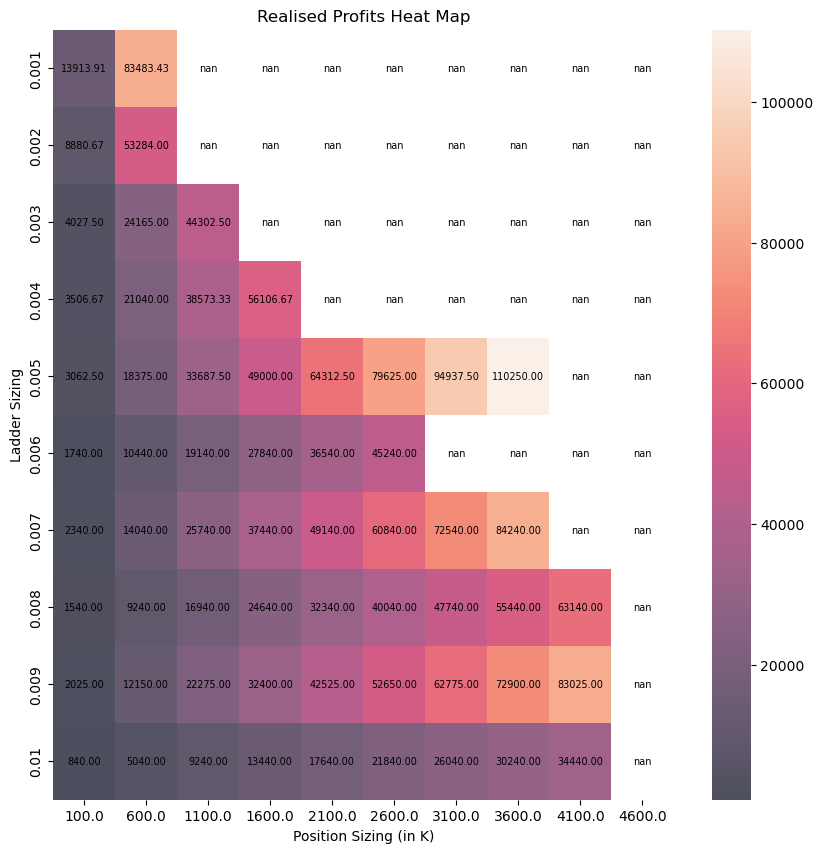

In [7]:
def profit_heat_map_for_gridsearch(profits, ladder_sizing, position_sizing, title):
    plt.figure(figsize=(10,10))
    
    position_sizing_in_K = np.array(position_sizing) / 1000
    
    ax = sns.heatmap(profits, cbar=True, alpha=0.7)
    
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=7)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing_in_K)
    
    rounded_labels = [round(val, 3) for val in ladder_sizing]  # Rounding to 3 decimal places
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, rounded_labels)
    
    plt.xlabel('Position Sizing (in K)')
    plt.ylabel('Ladder Sizing')
    plt.title(title + ' Heat Map')
    plt.show()

profit_heat_map_for_gridsearch(R_PNL_matrix, G_values, n_values, 'Realised Profits')


## Random Search

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# For G: Values between 0.001 and 0.01 with an interval of 0.001
G_values = np.arange(0.001, 0.011, 0.001)  # 0.011 is the stop value to include 0.01

# For n: Values from 100000 to 5000000 with an interval of 500000
n_values = np.arange(100000, 5000001, 500000)  # 5000001 is the stop value to include 5000000

# Initialize a matrix for storing R_PNL values
R_PNL_matrix = np.zeros((len(G_values), len(n_values)))

# only optimize G and n
best_profit = float('-inf')
best_G = None
best_n = None

# Random Search with 50 iterations
for iteration in range(50):
    G = np.random.choice(G_values)
    n = np.random.choice(n_values)

    # Find index in G_values and n_values for storing in R_PNL_matrix
    i = np.where(G_values == G)[0][0]
    j = np.where(n_values == n)[0][0]
    
    # Calculate results once for each (G, n) pair
    profit, U_PNL, max_position, R_PNL = run_strategy_optimised(tick_data, G, n)

    # Check constraints using stored results
    constraint1_okay = (max_position <= 10e6)
    constraint2_okay = (U_PNL >= -150e3)

    if constraint1_okay and constraint2_okay:
        R_PNL_matrix[i, j] = R_PNL
        if R_PNL > best_profit:
            best_profit = R_PNL
            best_G = G
            best_n = n
    else:
        R_PNL_matrix[i, j] = np.nan

if best_G is not None:
    print(f"Optimal G: {best_G}")
    print(f"Optimal n: {best_n}")
    print(f"Optimal net profit: {best_profit}")
else:
    print("No feasible solution found.")

Optimal G: 0.005
Optimal n: 3100000
Optimal net profit: 94937.5


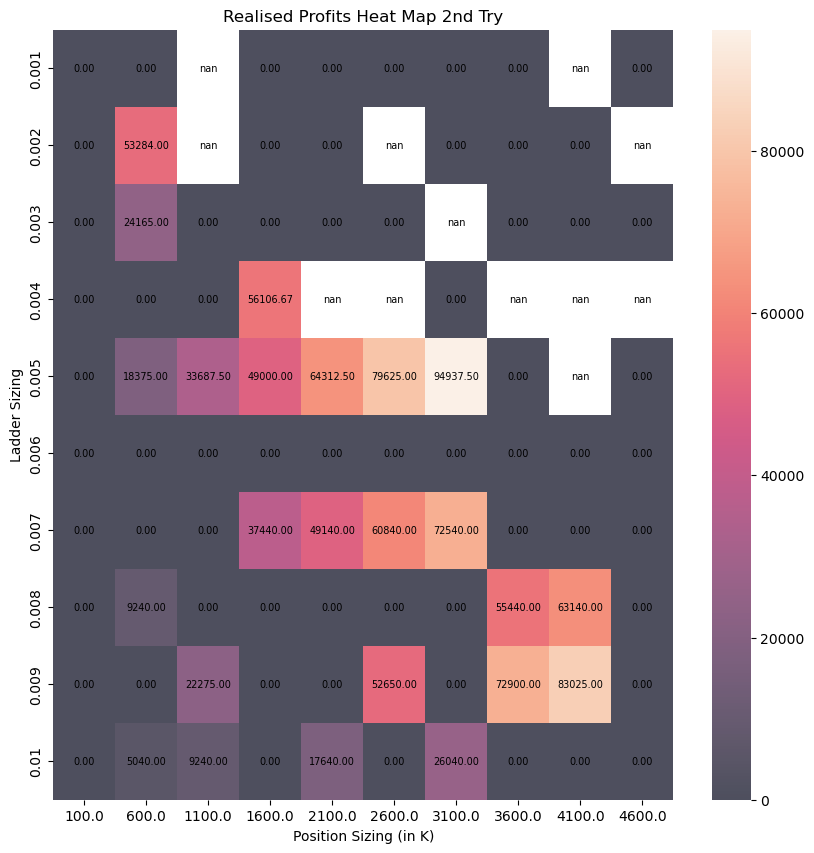

In [10]:
def profit_heat_map_random(profits, ladder_sizing, position_sizing, title):
    plt.figure(figsize=(10,10))
    
    # Convert position sizing to units of K for annotations and axis labels
    position_sizing_in_K = np.array(position_sizing) / 1000
    
    # Create the heatmap without annotations
    ax = sns.heatmap(profits, cbar=True, alpha=0.7)
    
    # Manually add annotations shifted by the desired amount
    for i in range(len(ladder_sizing)):
        for j in range(len(position_sizing)):
            ax.text(j+0.5, i+0.5, f"{profits[i, j]:.2f}", 
                    ha='center', va='center', color='black', fontsize=7)
    
    plt.xticks(np.arange(len(position_sizing)) + 0.5, position_sizing_in_K)
    
    # Round the ladder_sizing values for ytick labels
    rounded_labels = [round(val, 3) for val in ladder_sizing]  # Rounding to 3 decimal places
    plt.yticks(np.arange(len(ladder_sizing)) + 0.5, rounded_labels)
    
    plt.xlabel('Position Sizing (in K)')
    plt.ylabel('Ladder Sizing')
    plt.title(title + ' Heat Map 2nd Try')
    plt.show()

profit_heat_map_random(R_PNL_matrix, G_values, n_values, 'Realised Profits')
